In [18]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
import re
import sys
from pathlib import Path
from typing import Dict, List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [20]:
src_path: str = "../src"
sys.path.append(src_path)

In [21]:
ROOT: Path = Path("/media/ssd/Perez/storage/PCTA_WCDT_GSE221601_FILTERED")
FIGURES_PATH: Path = ROOT.joinpath("manuscript_figures")
FIGURES_PATH.mkdir(parents=True, exist_ok=True)

In [22]:
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = "Ubuntu Mono"
plt.rcParams["font.monospace"] = "Ubuntu Mono"

## WGCNA

---


Setup

In [23]:
WGCNA_EXP_NAMES: Dict[str, str] = {
    "prim/norm": "sample_type_hspc+mcrpc+norm+prim__prim_vs_norm_padj_0_05_up_1_0",
    "hspc/prim": "sample_type_hspc+mcrpc+norm+prim__hspc_vs_prim_padj_0_05_up_1_0",
    "mcrpc/hspc": "sample_type_hspc+mcrpc+norm+prim__mcrpc_vs_hspc_padj_0_05_up_1_0",
}

In [24]:
wgcna_inter_results = pd.read_csv(
    ROOT
    / "integrative_analysis/intersecting_wgcna/comparison_0_padj_0_05_up_1_0_bicor_signed_intersecting_wgcna_M3+M2+M1_ENTREZID_22.csv",
    index_col=0,
)
WGCNA_INT_GENES: List[str] = wgcna_inter_results.loc[
    wgcna_inter_results["prim_vs_norm_M3"]
    & wgcna_inter_results["hspc_vs_prim_M2"]
    & wgcna_inter_results["mcrpc_vs_hspc_M1"]
]["SYMBOL"].tolist()

In [25]:
def wgcna_violin_plot(
    wgcna_exp_name: str, exp_key: str, wgcna_genes: List[str]
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Creates a violin plot showing the distribution of log2 fold change values across WGCNA modules.

    Args:
        wgcna_exp_name (str): Name of the WGCNA experiment
        exp_key (str): Key for the experiment title
        wgcna_genes (List[str]): List of genes to annotate on the plot
    """
    # 1. Load hub genes data
    hub_genes_df = pd.read_csv(
        ROOT.joinpath("wgcna")
        .joinpath(wgcna_exp_name)
        .joinpath("standard")
        .joinpath("results")
        .joinpath("bicor_signed_hub_genes.csv"),
        index_col=0,
    )

    # 2. Create dictionary of module hub genes, excluding M0
    mod_hub_genes = hub_genes_df["SYMBOL"].to_dict()
    del mod_hub_genes["M0"]

    # 3. Load network genes data and filter out M0
    network_genes_df = pd.read_csv(
        ROOT.joinpath("wgcna")
        .joinpath(wgcna_exp_name)
        .joinpath("standard")
        .joinpath("results")
        .joinpath("bicor_signed_network_genes.csv"),
        index_col="SYMBOL",
    )
    network_genes_df = network_genes_df.loc[network_genes_df["module"] != "M0"]

    # 4. Create plot with specified size
    _, ax = plt.subplots(1, 1, figsize=(10, 10), dpi=300)

    # 5. Add strip plot for individual points
    ax = sns.stripplot(
        data=network_genes_df,
        x="module",
        y="log2FoldChange",
        hue="module",
        dodge=False,
        jitter=False,
        ax=ax,
    )

    # 6. Add violin plot showing distribution
    ax = sns.violinplot(
        data=network_genes_df,
        x="module",
        y="log2FoldChange",
        hue="module",
        dodge=False,
        ax=ax,
    )

    # 7. Annotate specified genes with arrows - Modified to prevent overlap
    # Filter and sort genes first
    genes_to_annotate = network_genes_df[
        network_genes_df.index.isin(wgcna_genes)
    ].sort_values("log2FoldChange")

    # Dictionary to store the last y-position for each x-position
    last_y_positions = {}
    min_y_spacing = 0.15  # Minimum vertical space between annotations

    for gene in genes_to_annotate.index:
        gene_meta = network_genes_df.loc[gene]
        mod_id = sorted(list(network_genes_df["module"].unique())).index(
            gene_meta["module"]
        )

        # Get exact coordinates where gene should be in the plot
        point_x = mod_id
        point_y = gene_meta["log2FoldChange"]

        # Base position for the annotation text - offset from the point
        text_x = point_x + 0.4  # Reduced horizontal offset
        text_y = point_y + 0.2

        # Adjust y-position if there's overlap
        if text_x in last_y_positions:
            if text_y - last_y_positions[text_x] < min_y_spacing:
                text_y = last_y_positions[text_x] + min_y_spacing

        # Store the new y-position
        last_y_positions[text_x] = text_y

        plt.annotate(
            gene,
            xy=(point_x, point_y),  # Where the arrow points to (exact gene position)
            xytext=(text_x, text_y),  # Where the text appears
            arrowprops=dict(
                facecolor="black",
                arrowstyle="->",
                connectionstyle="angle3,angleA=0,angleB=90",
            ),
            fontsize=10,
            ha="left",  # Align text to the left
        )

    # 8. Annotate hub genes for each module
    for mod_id, (mod, hub_gene) in enumerate(mod_hub_genes.items()):
        plt.annotate(
            hub_gene,
            xy=(mod_id, network_genes_df.loc[hub_gene, "log2FoldChange"]),
            xytext=(mod_id - 0.5, 0.25),
            ha="left",
            arrowprops=dict(
                facecolor="black", arrowstyle="->", connectionstyle="Angle3"
            ),
            fontweight="bold",
            fontsize=12,
        )

    # 9. Set plot labels and formatting
    plt.ylabel("Log₂ fold change", fontsize=14)
    plt.xlabel("WGCNA Module", fontsize=14)
    plt.xticks(
        np.arange(0, network_genes_df["module"].nunique(), 1),
        [f"{m}\n(n={c})" for m, c in network_genes_df["module"].value_counts().items()],
        fontsize=12,
    )
    plt.yticks(fontsize=12)
    plt.title(
        f"Distribution of LFC values in WGCNA modules ({exp_key}, up-regulated DEGs)",
        fontsize=16,
    )

    # 10. Final plot adjustments and save
    ax.set_axisbelow(True)
    plt.grid(axis="y", zorder=-10)
    plt.xlim((-1, network_genes_df["module"].nunique()))
    plt.legend([], [], frameon=False)
    plt.tight_layout()
    plt.savefig(FIGURES_PATH.joinpath(f"{wgcna_exp_name}_wgcna_violin_plot.pdf"))

    return hub_genes_df, network_genes_df

Violin plots

Creating violin plot for prim/norm...


/media/ssd/Perez/miniforge3/envs/bioinfo/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/media/ssd/Perez/miniforge3/envs/bioinfo/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/media/ssd/Perez/miniforge3/envs/bioinfo/lib/python3.12/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


Creating violin plot for hspc/prim...


/media/ssd/Perez/miniforge3/envs/bioinfo/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/media/ssd/Perez/miniforge3/envs/bioinfo/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/media/ssd/Perez/miniforge3/envs/bioinfo/lib/python3.12/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


Creating violin plot for mcrpc/hspc...


/media/ssd/Perez/miniforge3/envs/bioinfo/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/media/ssd/Perez/miniforge3/envs/bioinfo/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/media/ssd/Perez/miniforge3/envs/bioinfo/lib/python3.12/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


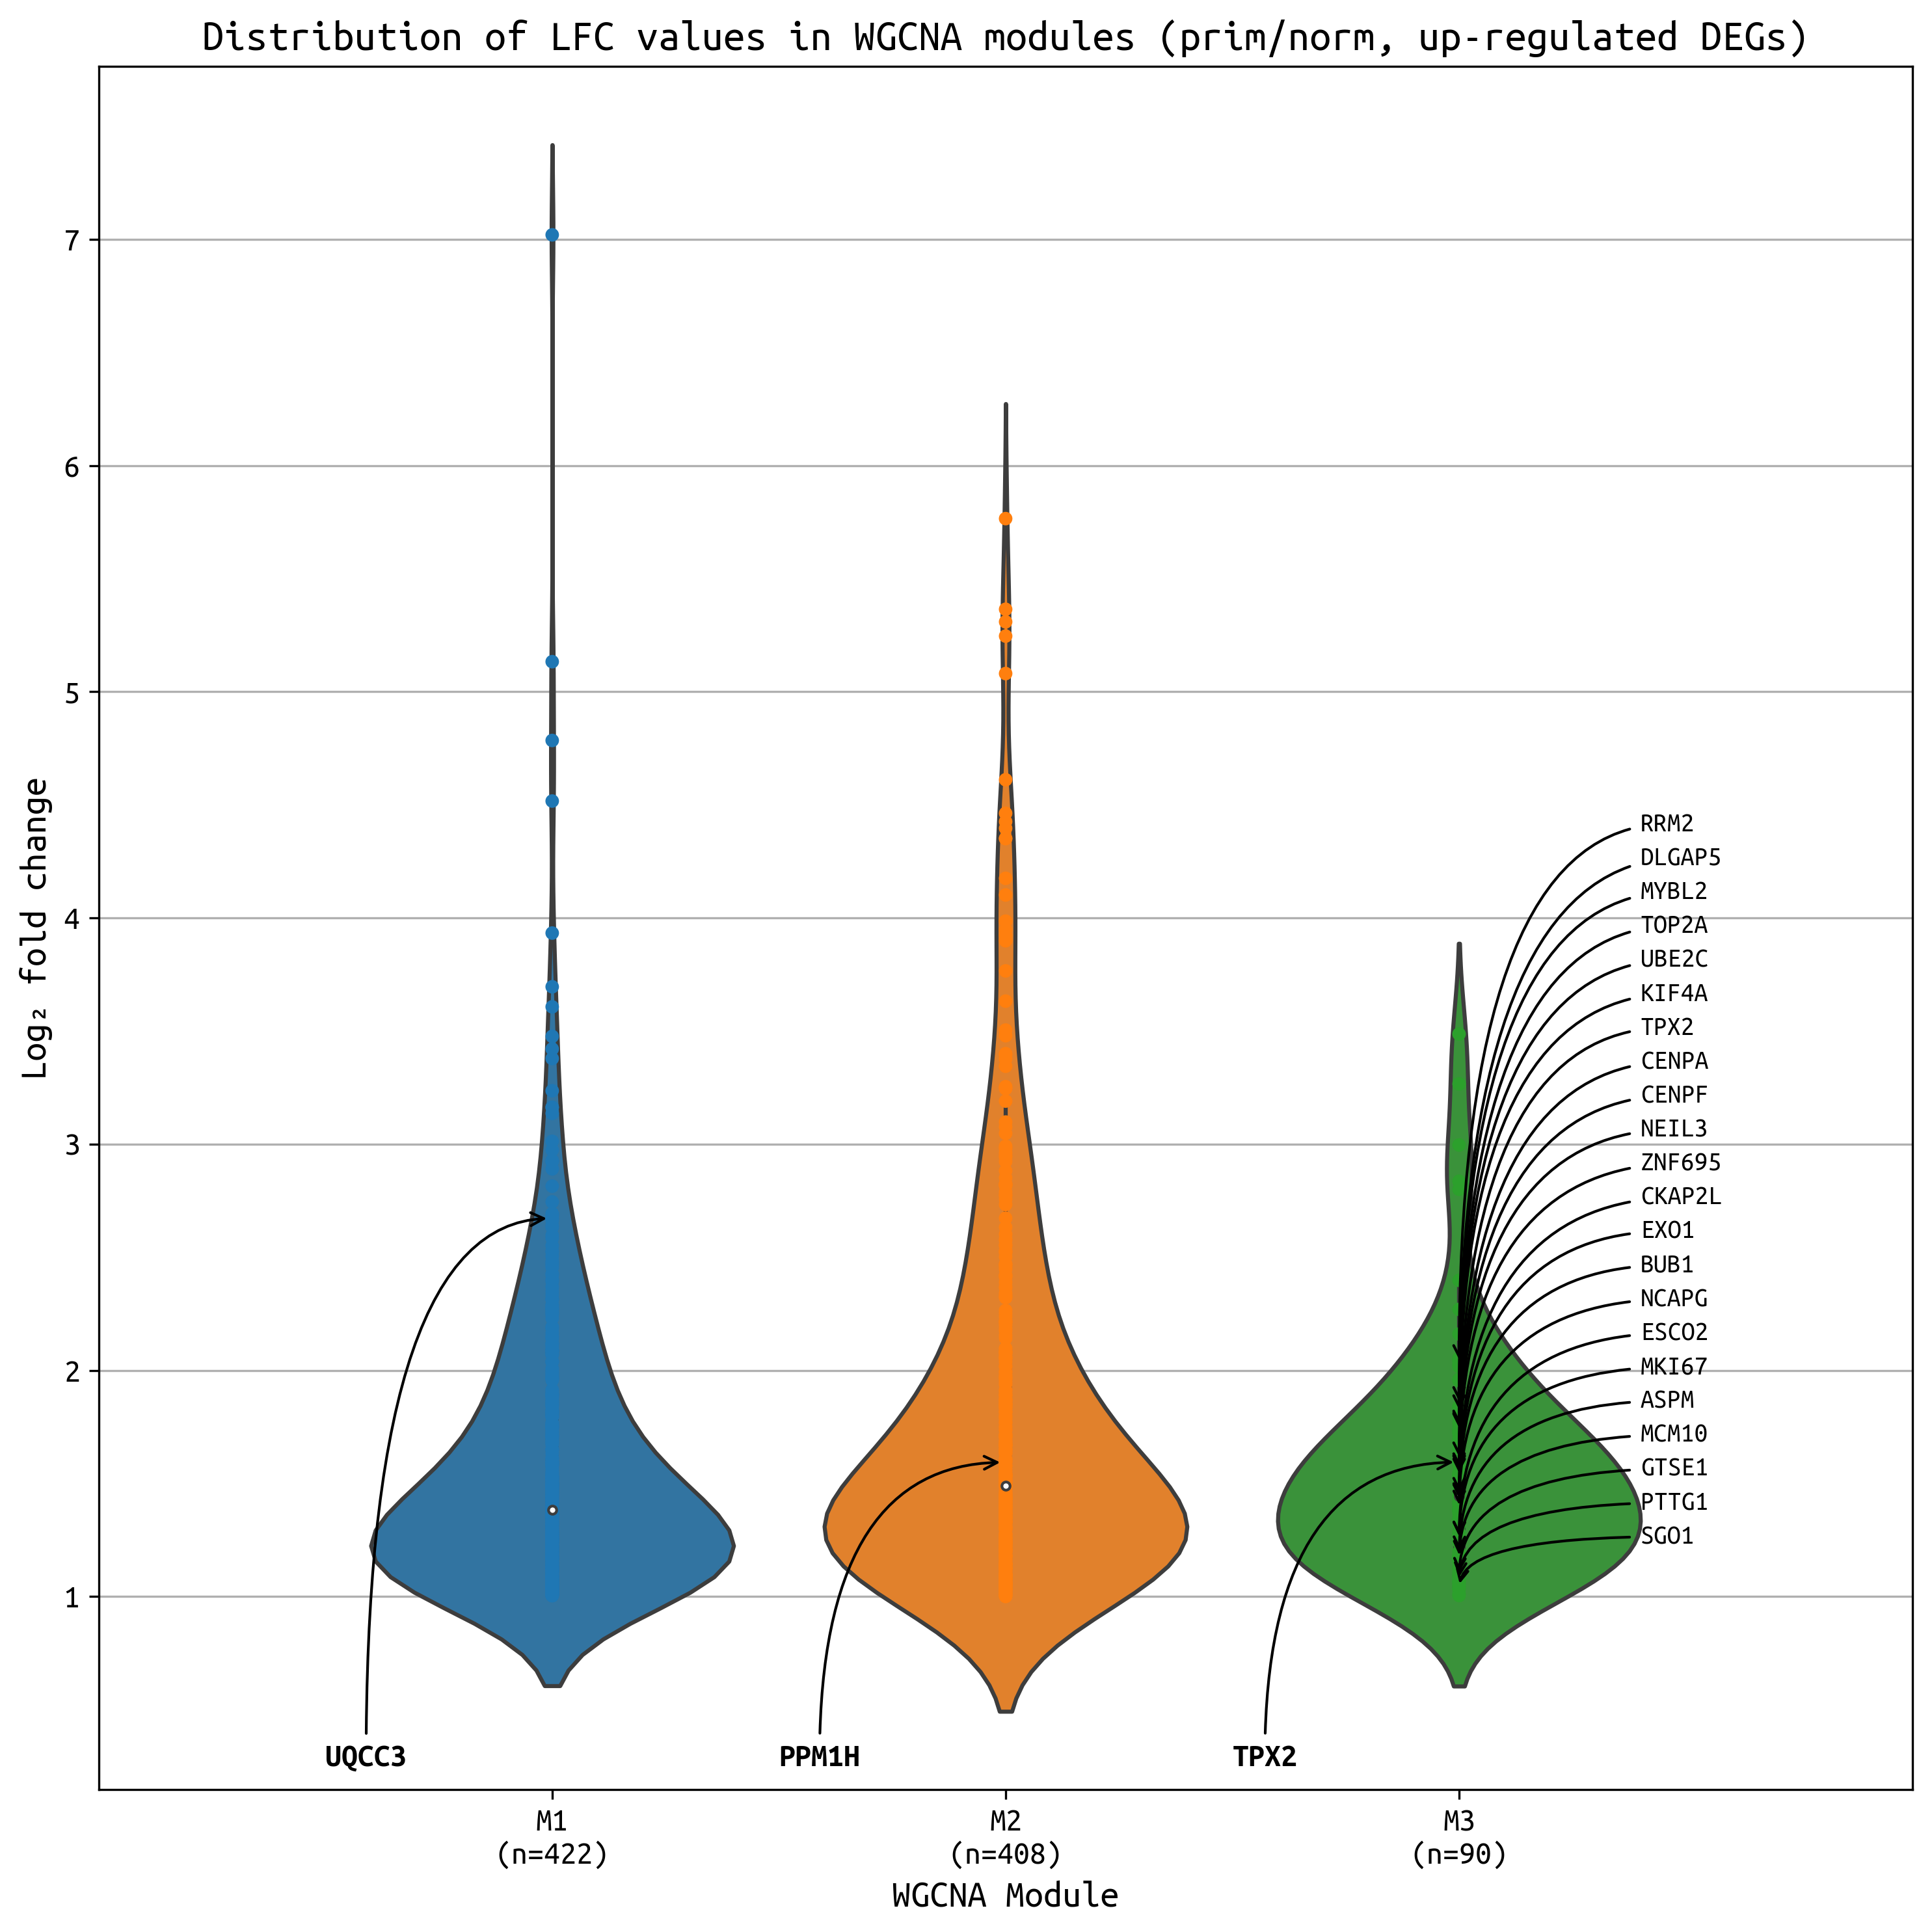

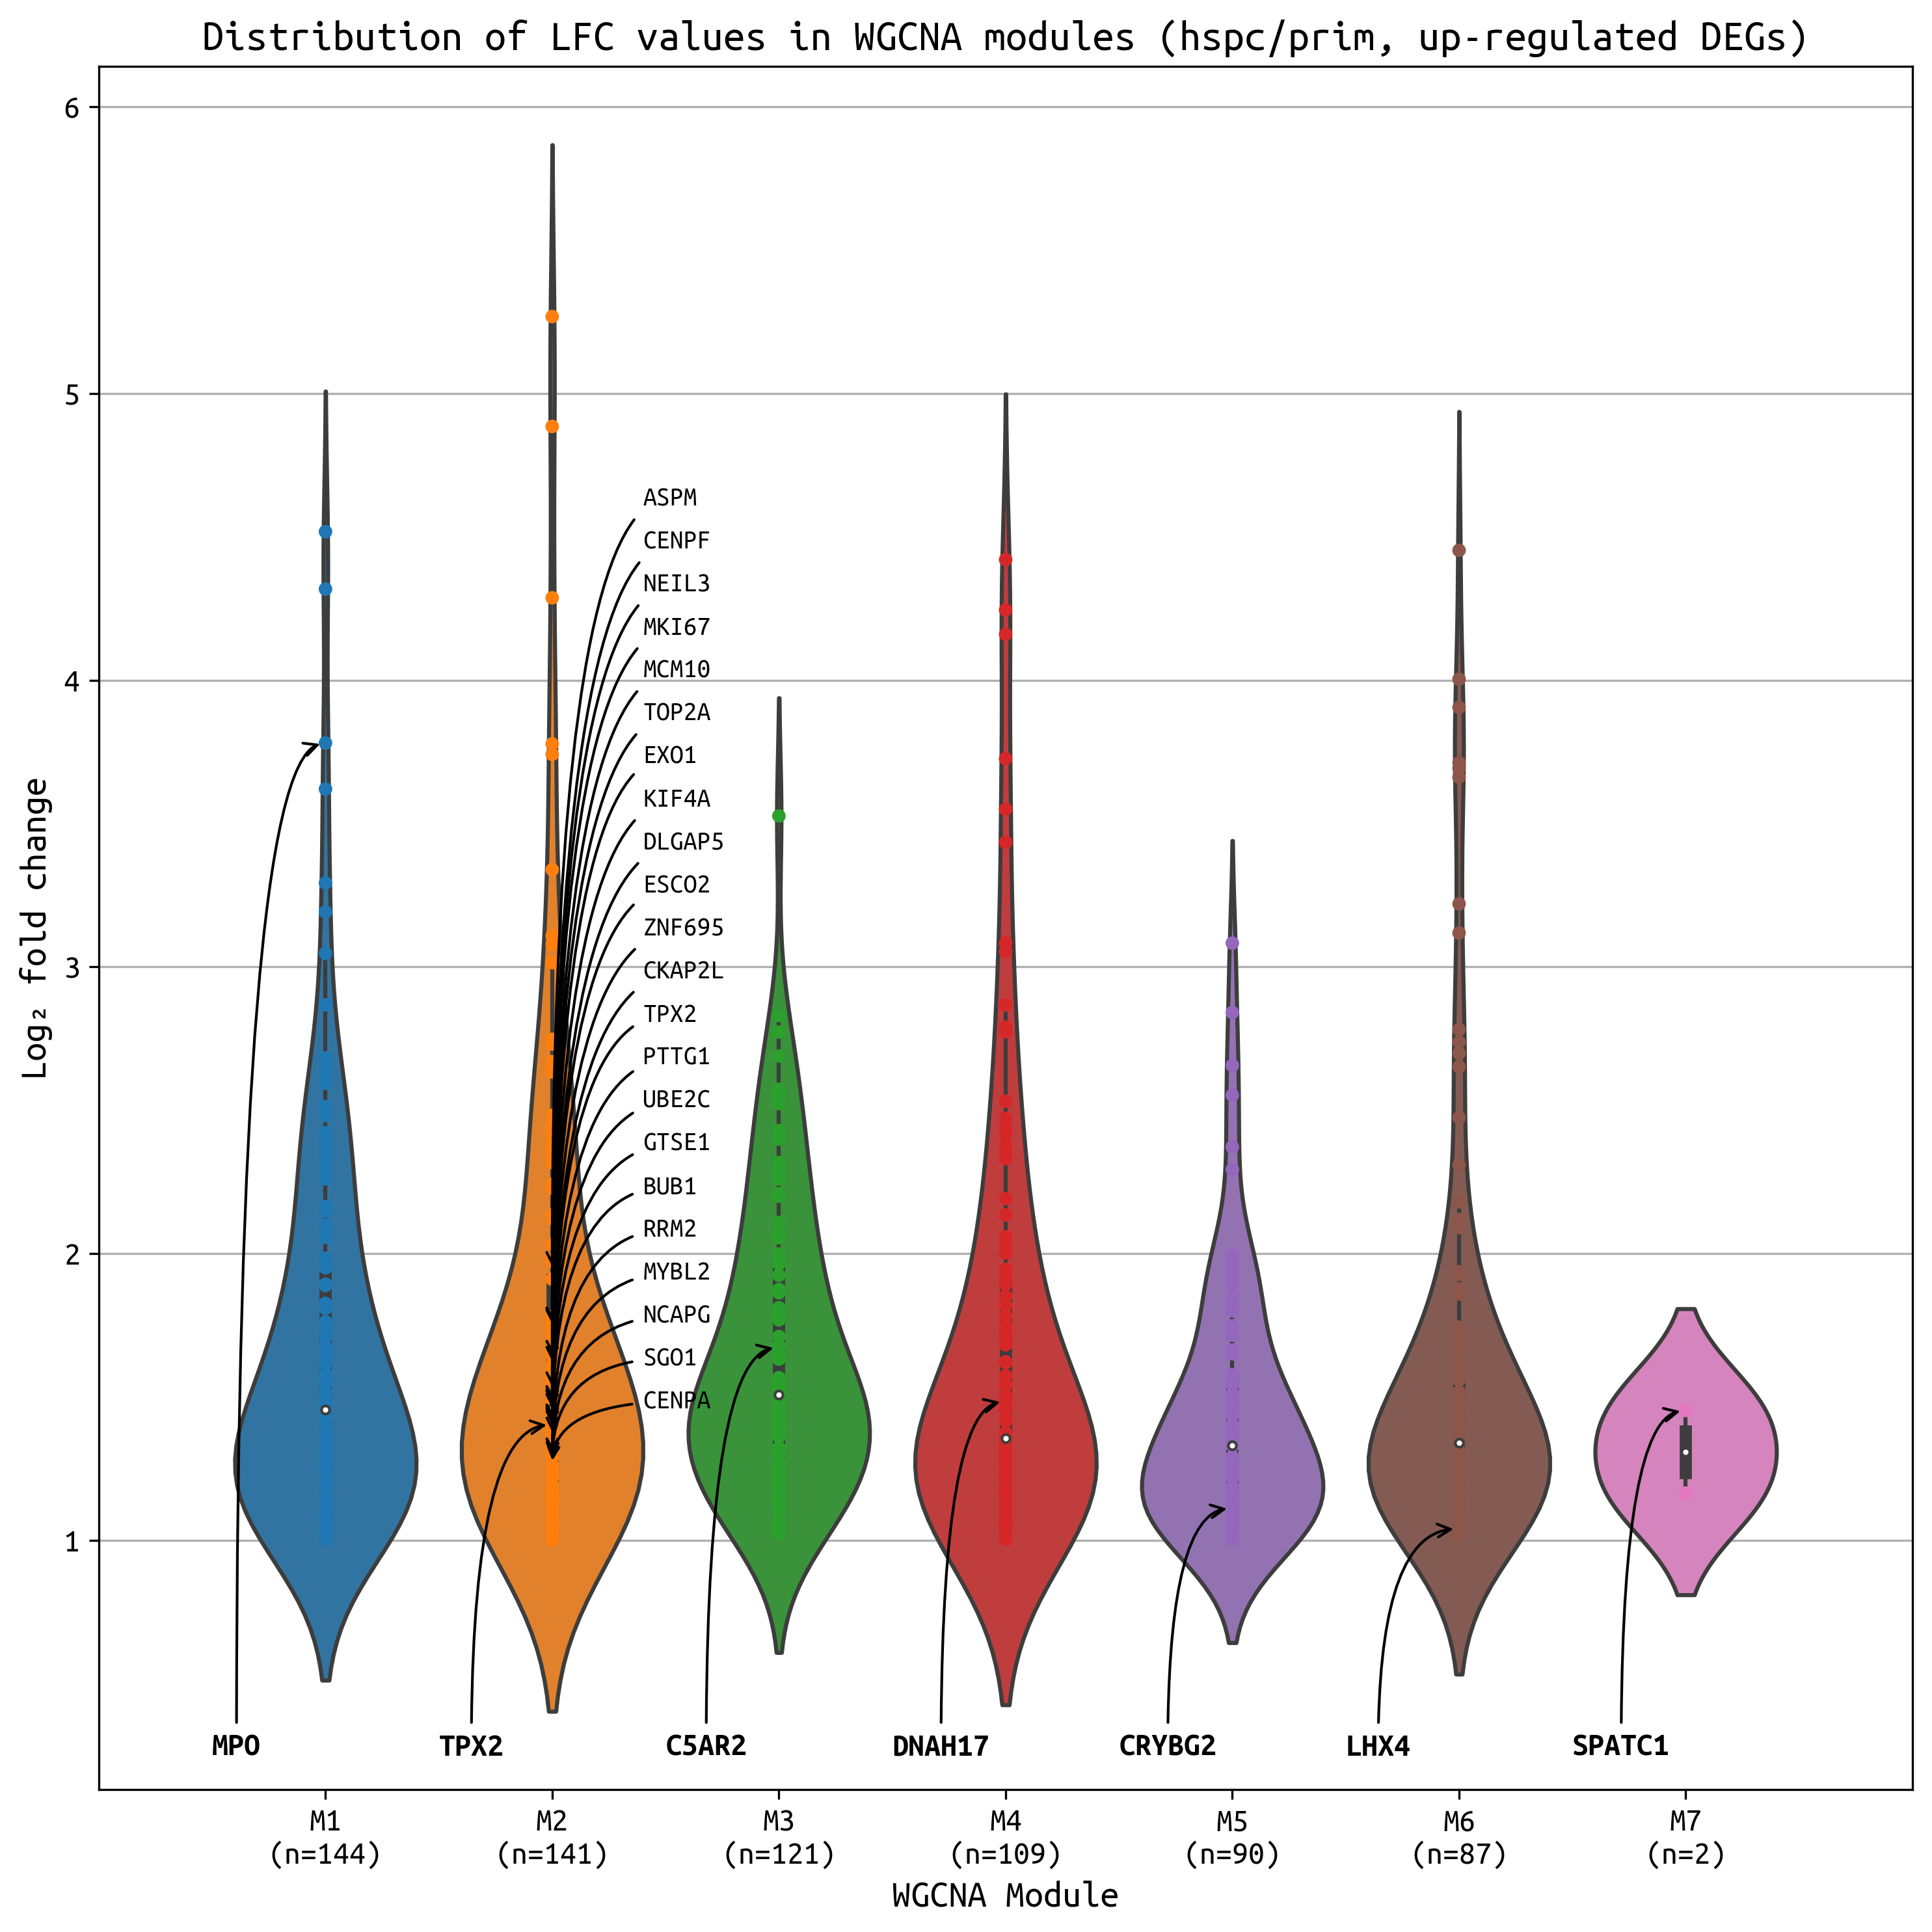

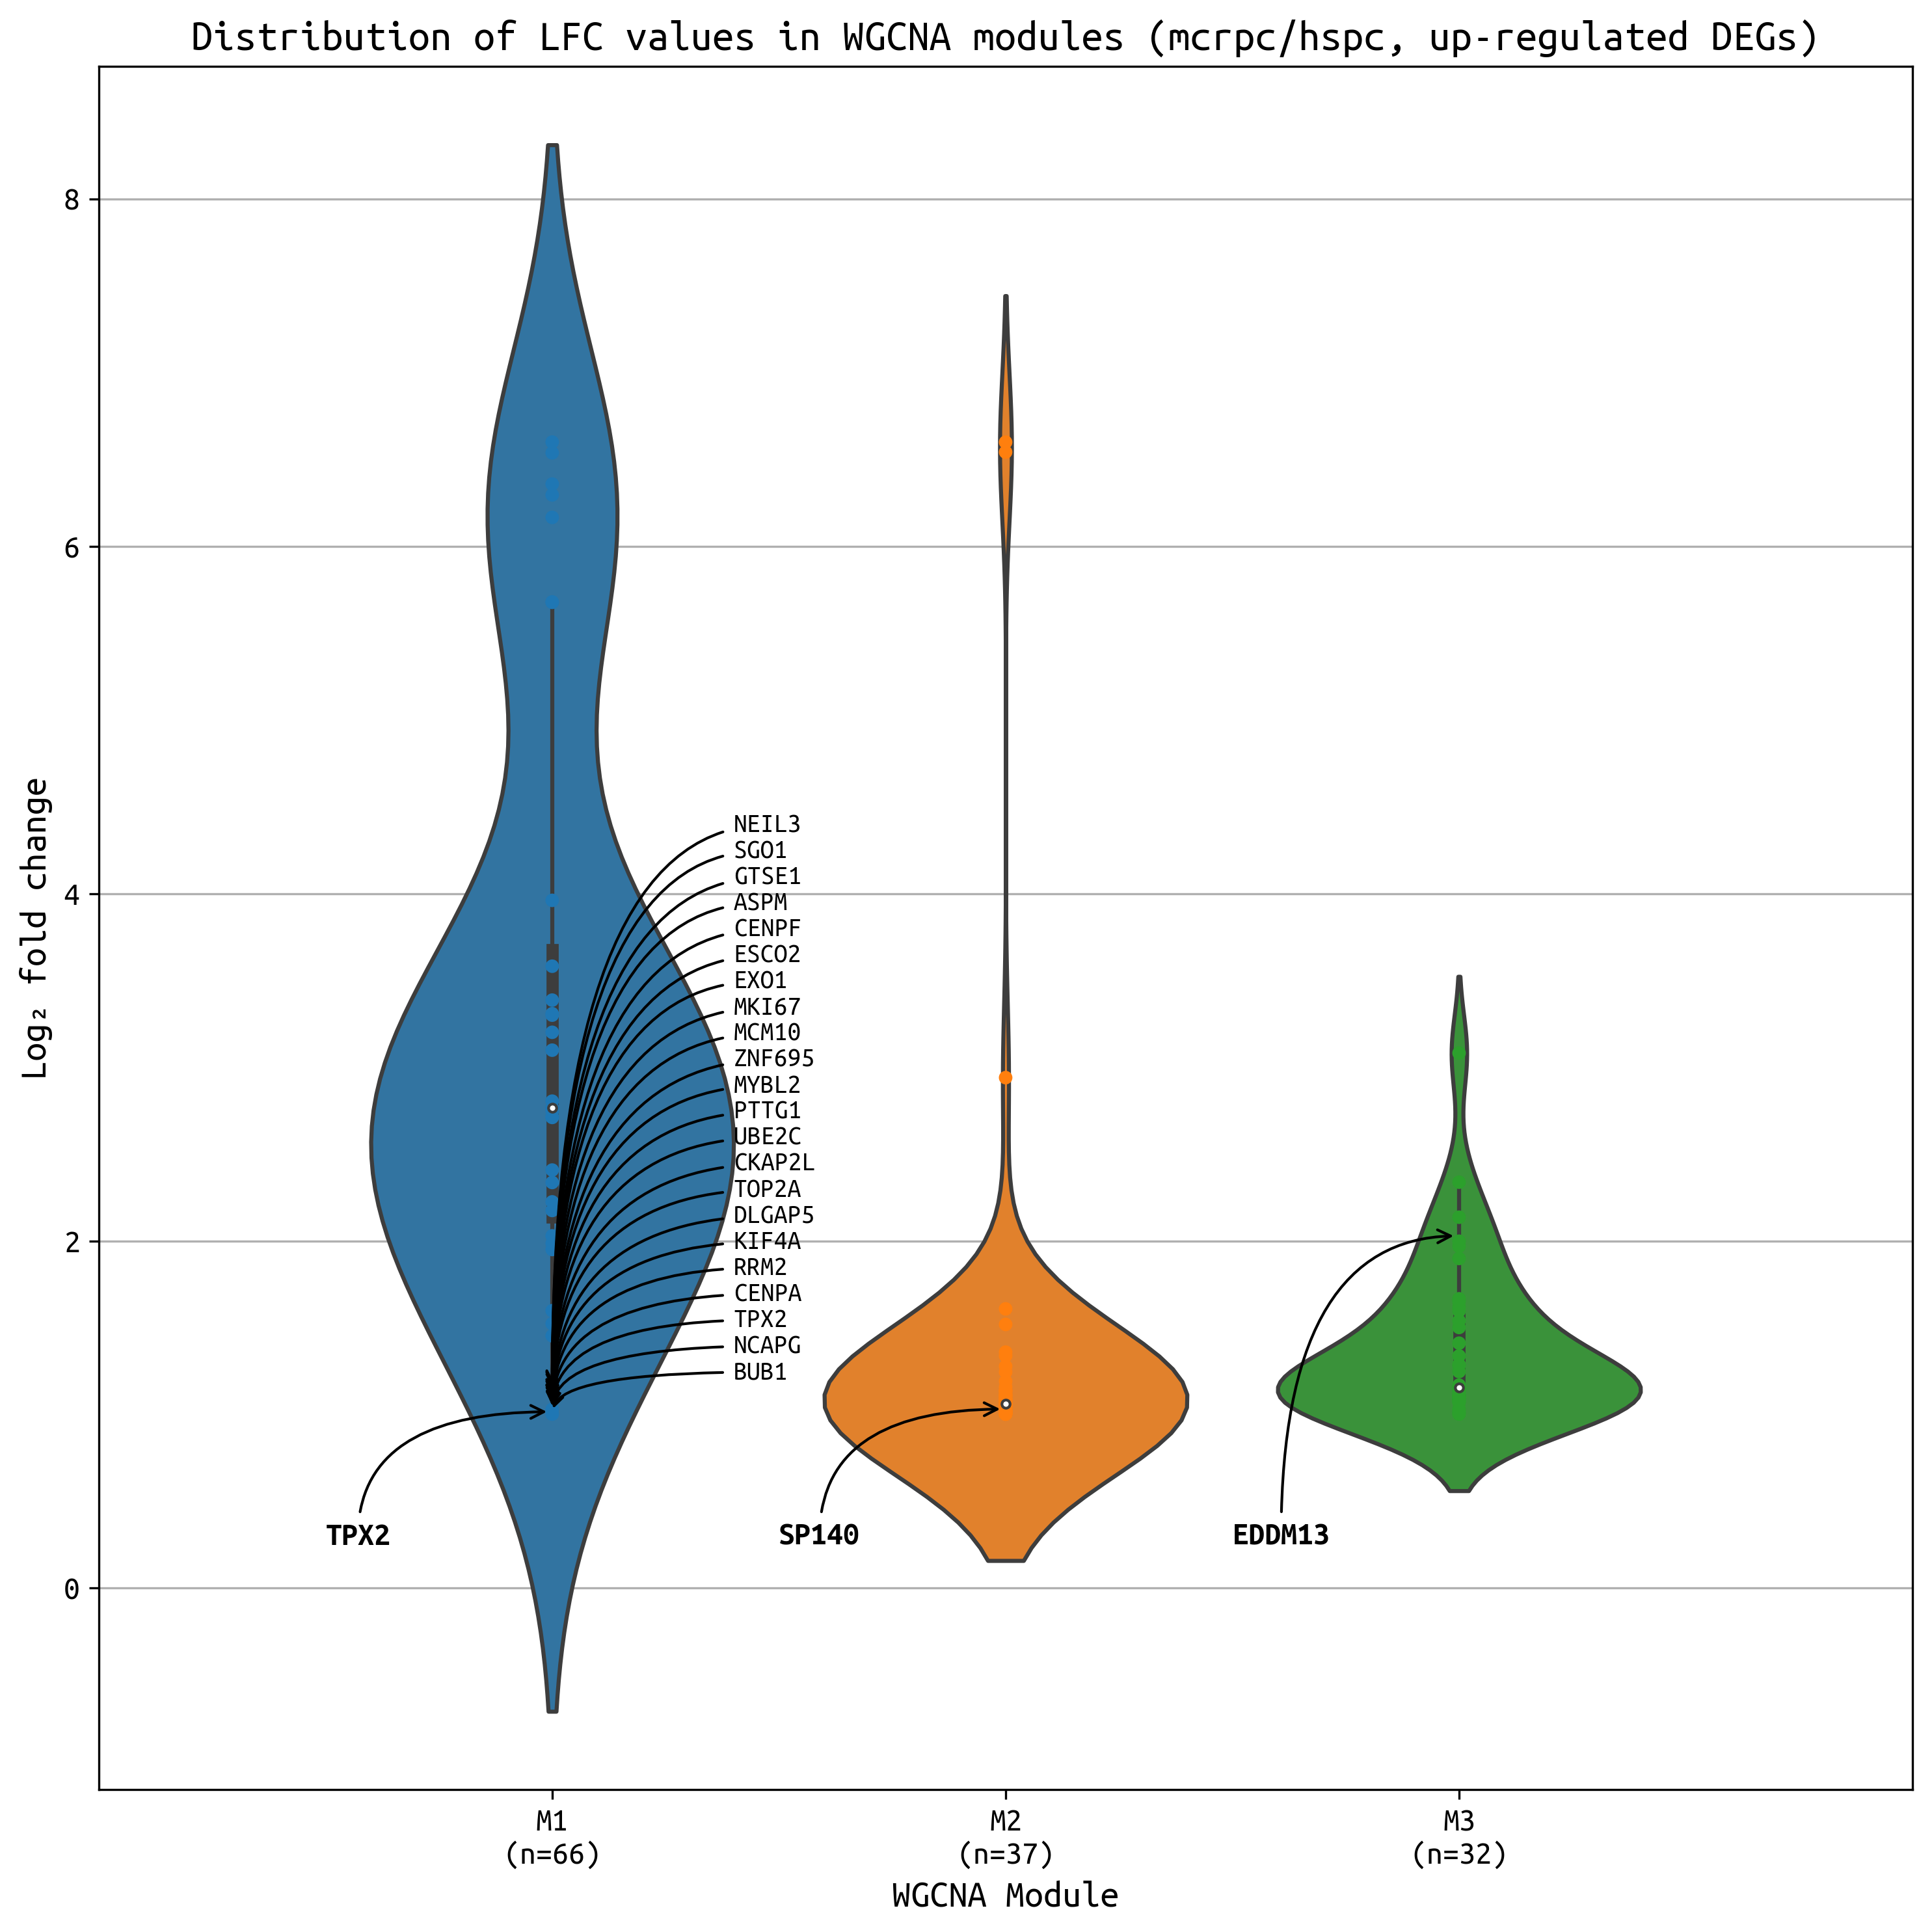

In [26]:
for exp_key, exp_name in WGCNA_EXP_NAMES.items():
    print(f"Creating violin plot for {exp_key}...")
    hub_genes_df, network_genes_df = wgcna_violin_plot(
        wgcna_exp_name=exp_name, exp_key=exp_key, wgcna_genes=WGCNA_INT_GENES
    )

## Additional files for WGCNA and ML analyses

---


In [27]:
SUPPLEMENTARY_FILES_PATH: Path = ROOT.joinpath("supplementary_files")
SUPPLEMENTARY_FILES_PATH.mkdir(parents=True, exist_ok=True)

### WGCNA

In [28]:
WGCNA_ROOT: Path = ROOT.joinpath("wgcna")
supplementary_file_wgcna = pd.ExcelWriter(
    SUPPLEMENTARY_FILES_PATH.joinpath("supplementary_file_wgcna.xlsx"),
    engine="openpyxl",
)

In [29]:
pattern = r"(prim_vs_norm|hspc_vs_prim|mcrpc_vs_hspc)"
for wgcna_contrast_file in sorted(
    list(WGCNA_ROOT.rglob("bicor_signed_network_genes.csv"))
):
    sheet_name = re.search(pattern, wgcna_contrast_file.parents[2].name).group(0)
    pd.read_csv(wgcna_contrast_file, index_col=0).to_excel(
        supplementary_file_wgcna, sheet_name=sheet_name
    )

In [30]:
supplementary_file_wgcna.close()

### ML

In [31]:
ML_ROOT: Path = ROOT.joinpath("ml_classifiers")
supplementary_file_ml = pd.ExcelWriter(
    SUPPLEMENTARY_FILES_PATH.joinpath("supplementary_file_ml.xlsx"),
    engine="openpyxl",
)

First-order SHAP values

In [32]:
pattern = r"(prim_vs_norm|hspc_vs_prim|mcrpc_vs_hspc)"
for contrast_shap_values_file in sorted(
    list(ML_ROOT.rglob("*/light_gbm/**/bootstrap_8192_shap_values.csv"))
):
    sheet_name = (
        re.search(pattern, contrast_shap_values_file.parents[3].name).group(0) + "_shap"
    )
    pd.read_csv(contrast_shap_values_file, index_col=0).to_excel(
        supplementary_file_ml, sheet_name=sheet_name
    )

Second-order SHAP values

In [33]:
pattern = r"(prim_vs_norm|hspc_vs_prim|mcrpc_vs_hspc)"
for contrast_shap_values_file in sorted(
    list(ML_ROOT.rglob("*/light_gbm/**/bootstrap_8192_shap_interaction_summary.csv"))
):
    sheet_name = (
        re.search(pattern, contrast_shap_values_file.parents[3].name).group(0)
        + "_interactions"
    )
    pd.read_csv(contrast_shap_values_file, index_col=0).to_excel(
        supplementary_file_ml, sheet_name=sheet_name
    )

In [34]:
supplementary_file_ml.close()